# R3 - Center Loss Classification for Image Similarity Assessment

In this notebook, we'll use classification with center loss to learn discriminative features that can be used for flower image similarity assessment.

## Project Overview

Building on our exploration of the 102 Flower Category Dataset, we'll:

1. Prepare the dataset with appropriate preprocessing (classification-based approach)
2. Implement a center loss-based classification network
3. Create a modular architecture with timm backbones
4. Train and evaluate our model on the flower similarity task
5. Compare the feature space with and without center loss

Center Loss helps create more discriminative feature embeddings by minimizing intra-class variations while the softmax loss separates different classes.

## Section 1: Environment Setup

First, let's install the necessary packages and import the required libraries.

In [27]:
# Install necessary packages
!pip install torch torchvision timm matplotlib seaborn scikit-learn pandas kaleido

In [28]:
# Import necessary libraries
import os
import glob
import time
import random
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

import random
import time
from PIL import Image
from torch.utils.data import Dataset
import torch
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

# Import timm for model backbones
import timm

# Import plotly for interactive plots
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")

# Enable inline plotting
%matplotlib inline

Remember the following candidate models as our network's backbone.

| Model                         | Module       | Top-1   | Param Count (M) | Selection Criteria |
|------------------------------|--------------|---------|------------------|--------------------|
| maxvit_large_tf_224.in1k     | maxxvit      | 84.934  | 211.79           | Top Accuracy       |
| maxvit_base_tf_224.in1k      | maxxvit      | 84.87   | 119.47           | Top Accuracy       |
| maxvit_small_tf_224.in1k     | maxxvit      | 84.456  | 68.93            | Top Accuracy       |
| gcvit_base.in1k              | gcvit        | 84.454  | 90.32            | Top Accuracy       |
| gcvit_small.in1k             | gcvit        | 83.908  | 51.09            | Top Accuracy       |
| tf_mixnet_s.in1k             | efficientnet | 75.652  | 4.13             | High Efficiency    |
| regnety_004.tv2_in1k         | regnet       | 75.588  | 4.34             | High Efficiency    |
| repghostnet_111.in1k         | repghost     | 75.068  | 4.54             | High Efficiency    |
| tf_mixnet_m.in1k             | efficientnet | 76.964  | 5.01             | High Efficiency    |
| tiny_vit_5m_224.in1k         | tiny_vit     | 79.196  | 5.39             | High Efficiency    |
| gcvit_tiny.in1k              | gcvit        | 83.4    | 28.22            | Compact Size       |
| tiny_vit_21m_224.in1k        | tiny_vit     | 83.27   | 21.2             | Compact Size       |
| coat_small.in1k              | coat         | 82.376  | 21.69            | Compact Size       |
| sequencer2d_s.in1k           | sequencer    | 82.336  | 27.65            | Compact Size       |
| coat_lite_small.in1k         | coat         | 82.302  | 19.84            | Compact Size       |

In [29]:
# Set global seeds for reproducibility
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(42)

# Set global configuration
CONFIG = {
    # Output directory
    'output_dir': 'output',
    'model_dir': 'model',

    # Training parameters
    'epochs': 10,
    'batch_size': 32,
    'learning_rate': 0.0001,
    'weight_decay': 1e-5,
    'center_loss_weight': 0.01,

    # Model parameters
    'backbone': 'tiny_vit_5m_224.in1k',
    'embedding_dim': 512,
    'image_size': 224,
    'num_classes': 102,

    # Training mode (options: 'full_training', 'fine_tuning', 'transfer_learning')
    'training_mode': 'fine_tuning',

    # Other settings
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
}

print(f"Using device: {CONFIG['device']}")
print(f"Selected backbone model: {CONFIG['backbone']}")

# Create output directories if they don't exist
os.makedirs(CONFIG['output_dir'], exist_ok=True)
os.makedirs(CONFIG['model_dir'], exist_ok=True)

Using device: cuda
Selected backbone model: tiny_vit_5m_224.in1k


## Section 2: Dataset Loading and Preparation

Now, let's load the data from the previous notebook. If needed, we'll also download and extract the dataset.

In [30]:
# Check if dataset files exist, download if necessary
if not os.path.exists('imagelabels.mat') or not os.path.exists('setid.mat'):
    print("Downloading dataset files...")

    if not os.path.exists('102flowers.tgz'):
        !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

    if not os.path.exists('imagelabels.mat'):
        !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

    if not os.path.exists('setid.mat'):
        !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat

    if not os.path.exists('jpg'):
        !tar -xzf 102flowers.tgz

    print("Download and extraction complete.")
else:
    print("Dataset files already exist.")

Dataset files already exist.


In [31]:
# Helper function to load MAT files with fallback
def load_mat(filepath):
    """Load MAT file with fallback to h5py for newer MAT file formats."""
    try:
        from scipy.io import loadmat
        return loadmat(filepath)
    except:
        import h5py
        with h5py.File(filepath, 'r') as f:
            data = {key: value[:] for key, value in f.items()}
        return data

# Load image labels and dataset split information
image_labels = load_mat("imagelabels.mat")
setid = load_mat("setid.mat")

# Extract labels and dataset splits
labels = image_labels["labels"][0]
train_ids = setid["tstid"][0] if "tstid" in setid else setid["tst"][0]
validation_ids = setid["valid"][0]
test_ids = setid["trnid"][0] if "trnid" in setid else setid["trn"][0]

# Adjust indices to be 0-indexed
train_ids = [idx - 1 for idx in train_ids]  # Convert to 0-indexed
validation_ids = [idx - 1 for idx in validation_ids]  # Convert to 0-indexed
test_ids = [idx - 1 for idx in test_ids]  # Convert to 0-indexed

# Create image paths
image_dir = 'jpg'
all_image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))

# Map indices to paths and labels
train_image_paths = [all_image_paths[idx] for idx in train_ids]
train_labels = [labels[idx] for idx in train_ids]

val_image_paths = [all_image_paths[idx] for idx in validation_ids]
val_labels = [labels[idx] for idx in validation_ids]

test_image_paths = [all_image_paths[idx] for idx in test_ids]
test_labels = [labels[idx] for idx in test_ids]

# Print dataset statistics
print(f"Train set: {len(train_image_paths)} images")
print(f"Validation set: {len(val_image_paths)} images")
print(f"Test set: {len(test_image_paths)} images")
print(f"Number of classes: {len(set(labels))}")

Train set: 6149 images
Validation set: 1020 images
Test set: 1020 images
Number of classes: 102


## Section 3: Center Loss Implementation

In this section, we'll implement the Center Loss function to improve feature discrimination. Center Loss was introduced in the paper "A Discriminative Feature Learning Approach for Deep Face Recognition" (ECCV 2016) by Wen et al.

Center Loss simultaneously learns a center for deep features of each class and penalizes the distances between the deep features and their corresponding class centers. By combining softmax loss and center loss, we aim to enhance the discriminative power of the learned features.

The basic idea is:
1. Softmax loss encourages inter-class separation
2. Center loss encourages intra-class compactness
3. Together, they create more discriminative features

In [32]:
class CenterLoss(nn.Module):
    """
    Center loss.

    Reference:
        Wen et al. "A Discriminative Feature Learning Approach for Deep Face Recognition." ECCV 2016.

    Args:
        num_classes (int): Number of classes.
        feat_dim (int): Feature dimension (embedding size).
        use_gpu (bool): Whether to use GPU for center storage.

    Forward Args:
        x (Tensor): Feature matrix of shape (batch_size, feat_dim).
        labels (Tensor): Ground truth labels of shape (batch_size,).

    Returns:
        loss (Tensor): Scalar center loss value, which encourages features of the same class to be close to their class center.
    """
    def __init__(self, num_classes=10, feat_dim=2, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        # Initialize centers for each class as learnable parameters
        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Compute the center loss.

        Args:
            x (Tensor): Feature matrix with shape (batch_size, feat_dim).
            labels (Tensor): Ground truth labels with shape (batch_size,).

        Returns:
            loss (Tensor): Scalar center loss value.
        """
        batch_size = x.size(0)

        # Compute squared Euclidean distance between each feature and each class center
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(x, self.centers.t(), beta=1, alpha=-2)

        # Create a mask for the ground truth class of each sample
        classes = torch.arange(self.num_classes).long()
        if self.use_gpu:
            classes = classes.cuda()
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        # Only keep distances to the correct class center for each sample
        dist = distmat * mask.float()

        # Compute the mean loss over the batch
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

## Section 4: Dataset Classes

We need to create two types of datasets:
1. A standard classification dataset for training with center loss
2. A pair-based dataset for evaluating similarity performance

In [33]:
class FlowerClassificationDataset(Dataset):
    """Dataset for classification with center loss - returns single images with their class labels"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Get label (class index, 0-indexed)
        # Adjust labels to be 0-indexed
        label = self.labels[idx] - 1  # assuming labels are 1-indexed

        return image, label

class FlowerPairDataset(Dataset):
    """Dataset for evaluating similarity - returns pairs of images with similarity labels"""
    def __init__(self, image_paths, labels, transform=None,
                 total_neg_pairs=None, seed=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

        # Set random seed for reproducibility
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        # Group images by class
        self.class_indices = {}
        for i, label in enumerate(self.labels):
            if label not in self.class_indices:
                self.class_indices[label] = []
            self.class_indices[label].append(i)

        self.indices1 = list(range(len(self.image_paths)))
        self._create_pairs()

    def _create_pairs(self):
        """Generate fair positive and negative pairs dynamically."""
        np.random.shuffle(self.indices1)  # Shuffle for randomness

        # 50% positive, 50% negative
        select_pos_pair = np.random.rand(len(self.indices1)) < 0.5

        self.pairs = []
        self.pair_labels = []

        for i, pos in zip(self.indices1, select_pos_pair):
            class1 = self.labels[i]

            if pos:
                # Positive pair: same class
                same_class_indices = [idx for idx in self.class_indices[class1] if idx != i]
                if same_class_indices:
                    j = np.random.choice(same_class_indices)
                else:
                    j = i  # fallback: pair with self if no other choice
                label = 1
            else:
                # Negative pair: different class
                other_classes = list(set(self.class_indices.keys()) - {class1})
                class2 = np.random.choice(other_classes)
                j = np.random.choice(self.class_indices[class2])
                label = 0

            self.pairs.append((i, j))
            self.pair_labels.append(label)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        idx1, idx2 = self.pairs[idx]

        # Load images
        img1 = Image.open(self.image_paths[idx1]).convert('RGB')
        img2 = Image.open(self.image_paths[idx2]).convert('RGB')

        # Apply transformations
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        # Get pair label and class labels
        pair_label = self.pair_labels[idx]
        class1 = self.labels[idx1]
        class2 = self.labels[idx2]

        # Return a tuple of (images, target, class_labels)
        return (img1, img2), torch.FloatTensor([pair_label]), (class1, class2)

In [35]:
# Create data loaders for both approaches
def create_dataloaders(image_paths, labels, val_image_paths, val_labels,
                       test_image_paths, test_labels, config):
    """Create dataloaders for training, validation, and test sets."""

    # Data transformations
    train_transform = transforms.Compose([
        transforms.Resize((CONFIG['image_size'] + 32, CONFIG['image_size'] + 32)),
        transforms.RandomCrop(CONFIG['image_size']),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((config['image_size'], config['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create classification datasets
    train_dataset = FlowerClassificationDataset(image_paths, labels, train_transform)

    # Create pair datasets for validation and test
    val_dataset = FlowerPairDataset(val_image_paths, val_labels, val_transform)
    test_dataset = FlowerPairDataset(test_image_paths, test_labels, val_transform)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

## Section 5: Network Architecture

We'll create a network architecture that supports both classification and feature extraction for similarity assessment.

In [36]:
class CenterLossNetwork(nn.Module):
    """
    Network architecture for classification with center loss.
    Features can be extracted for similarity assessment.
    """
    def __init__(self, backbone_name='resnet18', pretrained=True, embedding_dim=None,
                 training_mode='transfer_learning', num_classes=102):
        """
        Initialize the network.

        Args:
            backbone_name: Name of the backbone network from timm
            pretrained: Whether to use pretrained weights
            embedding_dim: Dimension of the embedding layer (None to skip embedding)
            training_mode: One of 'full_training', 'fine_tuning', 'transfer_learning'
            num_classes: Number of classes for the classification head
        """
        super(CenterLossNetwork, self).__init__()

        # Create backbone network from timm
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=pretrained,
            num_classes=0  # Remove classification head
        )

        # Apply training mode settings
        self.training_mode = training_mode
        self._apply_training_mode()

        # Get the output dimension of the backbone
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, CONFIG['image_size'], CONFIG['image_size'])
            backbone_output_dim = self.backbone(dummy_input).shape[1]

        print(f"Backbone: {backbone_name}, Output dimension: {backbone_output_dim}")
        print(f"Training mode: {training_mode}")

        # Optional embedding layer
        self.embedding_dim = embedding_dim
        if embedding_dim is not None:
            self.embedding = nn.Sequential(
                nn.Linear(backbone_output_dim, embedding_dim),
                nn.BatchNorm1d(embedding_dim),
                nn.ReLU(inplace=True)
            )
            final_dim = embedding_dim
        else:
            self.embedding = nn.Identity()
            final_dim = backbone_output_dim

        # Classification head
        self.classifier = nn.Linear(final_dim, num_classes)

    def _apply_training_mode(self):
        """Apply the selected training mode to the network"""
        if self.training_mode == 'transfer_learning':
            # Freeze the entire backbone
            for param in self.backbone.parameters():
                param.requires_grad = False
            print("Transfer learning mode: backbone frozen, only training embedding and classifier")

        elif self.training_mode == 'fine_tuning':
            # Freeze early layers, train later layers
            layers_to_freeze = []

            # Handle different model architectures
            if hasattr(self.backbone, 'stem'):
                # Vision transformer style models often have a stem
                layers_to_freeze.append('stem')

            if hasattr(self.backbone, 'stages') and len(self.backbone.stages) > 2:
                # For models with stages (like RegNet, ConvNext, etc.)
                # Freeze early stages, keep later ones trainable
                early_stages = len(self.backbone.stages) // 2
                for i in range(early_stages):
                    layers_to_freeze.append(f'stages.{i}')

            elif hasattr(self.backbone, 'layer1'):
                # ResNet style models
                layers_to_freeze.extend(['conv1', 'bn1', 'act1', 'maxpool', 'layer1', 'layer2'])

            elif hasattr(self.backbone, 'blocks') and len(self.backbone.blocks) > 4:
                # Vision transformer style with blocks
                block_count = len(self.backbone.blocks)
                blocks_to_freeze = block_count // 2
                for i in range(blocks_to_freeze):
                    layers_to_freeze.append(f'blocks.{i}')

            # Apply freezing
            for name, param in self.backbone.named_parameters():
                param.requires_grad = True  # Default to trainable
                for layer_name in layers_to_freeze:
                    if layer_name in name:
                        param.requires_grad = False
                        break

            print(f"Fine-tuning mode: {len(layers_to_freeze)} early layers/blocks frozen, later layers trainable")

        else:  # full_training
            # Train the entire network
            for param in self.backbone.parameters():
                param.requires_grad = True
            print("Full training mode: all layers trainable")

    def forward(self, x, get_embedding=False):
        """
        Forward pass through the network.

        Args:
            x: Input image tensor [B, C, H, W]
            get_embedding: Whether to return features for similarity assessment

        Returns:
            logits: Classification logits [B, num_classes]
            features: Feature embeddings [B, embedding_dim] (if get_embedding=True)
        """
        # Extract features from the backbone
        features = self.backbone(x)

        # Apply embedding layer
        embeddings = self.embedding(features)

        # Return embeddings for similarity assessment or center loss
        if get_embedding:
            return embeddings

        # Classification head
        logits = self.classifier(embeddings)

        return logits, embeddings

    def compute_similarity(self, img1, img2):
        """
        Compute similarity between two images.

        Args:
            img1: First image tensor [B, C, H, W]
            img2: Second image tensor [B, C, H, W]

        Returns:
            similarity: Cosine similarity between the embeddings [B]
        """
        # Get embeddings
        with torch.no_grad():
            embed1 = self.forward(img1, get_embedding=True)
            embed2 = self.forward(img2, get_embedding=True)

            # Normalize embeddings
            embed1 = F.normalize(embed1, p=2, dim=1)
            embed2 = F.normalize(embed2, p=2, dim=1)

            # Compute cosine similarity
            similarity = torch.sum(embed1 * embed2, dim=1)

            # Scale to [0, 1] range
            similarity = torch.sigmoid(similarity * 5)

        return similarity

In [37]:
# Initialize the model
model = CenterLossNetwork(
    backbone_name=CONFIG['backbone'],
    pretrained=True,
    embedding_dim=CONFIG['embedding_dim'],
    training_mode=CONFIG['training_mode'],
    num_classes=CONFIG['num_classes']
)

# Move model to device
model = model.to(CONFIG['device'])

# Print model summary
print(f"Initialized network with {CONFIG['backbone']} backbone")
print(f"Feature embedding dimension: {CONFIG['embedding_dim']}")

Fine-tuning mode: 2 early layers/blocks frozen, later layers trainable
Backbone: tiny_vit_5m_224.in1k, Output dimension: 320
Training mode: fine_tuning
Initialized network with tiny_vit_5m_224.in1k backbone
Feature embedding dimension: 512


In [40]:
# Function to print model architecture and parameters
def print_model_summary(model):
    print("Parameters:")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Percentage of trainable parameters: {100. * trainable_params / total_params:.2f}%")
    print("\nModel Architecture:")
    print(model)

# Print the summary of the initialized model
print_model_summary(model)

Parameters:
  Total parameters: 5,289,466
  Trainable parameters: 4,790,770
  Percentage of trainable parameters: 90.57%

Model Architecture:
CenterLossNetwork(
  (backbone): TinyVit(
    (patch_embed): PatchEmbed(
      (conv1): ConvNorm(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (act): GELU(approximate='none')
      (conv2): ConvNorm(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (stages): Sequential(
      (0): ConvLayer(
        (blocks): Sequential(
          (0): MBConv(
            (conv1): ConvNorm(
              (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_ru

## Section 6: Loss Functions, Optimizer, and Metrics

Next, we'll define our loss functions, optimizer, and evaluation metrics for training and evaluating the network.

In [41]:
# Define loss functions
criterion_xent = nn.CrossEntropyLoss()
criterion_cent = CenterLoss(num_classes=CONFIG['num_classes'],
                            feat_dim=CONFIG['embedding_dim'],
                            use_gpu=(CONFIG['device'].type=='cuda'))

# Define optimizers
optimizer = optim.Adam(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Separate optimizer for center loss
optimizer_centloss = optim.SGD(
    criterion_cent.parameters(),
    lr=0.5
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

# Function to compute classification accuracy
def compute_accuracy(outputs, targets):
    """
    Compute classification accuracy.

    Args:
        outputs: Model predictions (logits)
        targets: Ground truth labels

    Returns:
        accuracy: Classification accuracy
    """
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == targets).sum().item()
    accuracy = correct / targets.size(0)
    return accuracy

# Function to compute similarity metrics
def compute_similarity_metrics(outputs, targets, threshold=0.9):
    """
    Compute metrics for similarity prediction.

    Args:
        outputs: Similarity scores [N]
        targets: Ground truth labels [N]
        threshold: Similarity threshold [0-1]

    Returns:
        accuracy: Binary accuracy
        roc_auc: Area under ROC curve
    """
    # Convert to numpy
    outputs_np = outputs.cpu().detach().numpy()
    targets_np = targets.cpu().detach().numpy().flatten()

    # Compute accuracy
    predictions = (outputs_np >= threshold).astype(int)
    accuracy = (predictions == targets_np).mean()

    # Compute ROC-AUC
    try:
        from sklearn.metrics import roc_auc_score
        roc_auc = roc_auc_score(targets_np, outputs_np)
    except:
        # Fallback if there's an issue
        roc_auc = 0.5

    return accuracy, roc_auc

## Section 7: Training and Validation Functions

We'll define functions for training and validation with center loss.

In [42]:
# Training function
def train_epoch(model, train_loader, criterion_xent, criterion_cent,
                optimizer, optimizer_centloss, device, center_loss_weight=0.01):
    """
    Train for one epoch.

    Args:
        model: The network model
        train_loader: Training data loader
        criterion_xent: Cross entropy loss function
        criterion_cent: Center loss function
        optimizer: Optimizer for the model
        optimizer_centloss: Optimizer for center loss
        device: Device to use for computation
        center_loss_weight: Weight for center loss term

    Returns:
        epoch_loss: Average loss for the epoch
        epoch_acc: Average accuracy for the epoch
    """
    model.train()
    running_loss = 0.0
    running_xent_loss = 0.0
    running_cent_loss = 0.0
    running_acc = 0.0
    samples = 0

    # Progress bar
    pbar = tqdm(train_loader, desc="Training")

    for inputs, targets in pbar:
        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)

        # Zero the parameter gradients
        optimizer.zero_grad()
        optimizer_centloss.zero_grad()

        # Forward pass
        logits, features = model(inputs)

        # Compute losses
        xent_loss = criterion_xent(logits, targets)
        cent_loss = criterion_cent(features, targets)
        loss = xent_loss + center_loss_weight * cent_loss

        # Backward pass and optimize
        loss.backward()

        # Update parameters
        # Multiple (1./center_loss_weight) to remove the effect of center_loss_weight on updating centers
        for param in criterion_cent.parameters():
            param.grad.data *= (1. / center_loss_weight)

        optimizer.step()
        optimizer_centloss.step()

        # Compute accuracy
        acc = compute_accuracy(logits, targets)

        # Update statistics
        running_loss += loss.item() * batch_size
        running_xent_loss += xent_loss.item() * batch_size
        running_cent_loss += cent_loss.item() * batch_size
        running_acc += acc * batch_size
        samples += batch_size

        # Update progress bar
        pbar.set_postfix(
            loss=loss.item(),
            xent=xent_loss.item(),
            cent=cent_loss.item(),
            acc=acc
        )

    # Compute epoch statistics
    epoch_loss = running_loss / samples
    epoch_xent_loss = running_xent_loss / samples
    epoch_cent_loss = running_cent_loss / samples
    epoch_acc = running_acc / samples

    return epoch_loss, epoch_xent_loss, epoch_cent_loss, epoch_acc

# Validation function for classification
def validate_classification(model, val_loader, criterion_xent, criterion_cent,
                           device, center_loss_weight=0.01):
    """
    Validate the model on classification task.

    Args:
        model: The network model
        val_loader: Validation data loader (classification)
        criterion_xent: Cross entropy loss function
        criterion_cent: Center loss function
        device: Device to use for computation
        center_loss_weight: Weight for center loss term

    Returns:
        val_loss: Average validation loss
        val_xent_loss: Average cross-entropy loss
        val_cent_loss: Average center loss
        val_acc: Average validation accuracy
    """
    model.eval()
    running_loss = 0.0
    running_xent_loss = 0.0
    running_cent_loss = 0.0
    running_acc = 0.0
    samples = 0

    # Progress bar
    pbar = tqdm(val_loader, desc="Validating")

    with torch.no_grad():
        for inputs, targets in pbar:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)

            # Forward pass
            logits, features = model(inputs)

            # Compute losses
            xent_loss = criterion_xent(logits, targets)
            cent_loss = criterion_cent(features, targets)
            loss = xent_loss + center_loss_weight * cent_loss

            # Compute accuracy
            acc = compute_accuracy(logits, targets)

            # Update statistics
            running_loss += loss.item() * batch_size
            running_xent_loss += xent_loss.item() * batch_size
            running_cent_loss += cent_loss.item() * batch_size
            running_acc += acc * batch_size
            samples += batch_size

            # Update progress bar
            pbar.set_postfix(
                loss=loss.item(),
                xent=xent_loss.item(),
                cent=cent_loss.item(),
                acc=acc
            )

    # Compute validation statistics
    val_loss = running_loss / samples
    val_xent_loss = running_xent_loss / samples
    val_cent_loss = running_cent_loss / samples
    val_acc = running_acc / samples

    return val_loss, val_xent_loss, val_cent_loss, val_acc

# Validation function for similarity
def validate_similarity(model, val_loader, threshold, device):
    """
    Validate the model on similarity task.

    Args:
        model: The network model
        val_loader: Validation data loader (pairs)
        threshold: Similarity threshold
        device: Device to use for computation

    Returns:
        sim_acc: Similarity prediction accuracy
        sim_auc: ROC-AUC for similarity prediction
        threshold: Updated similarity threshold
    """
    model.eval()
    all_similarities = []
    all_targets = []
    running_acc = 0.0
    running_auc = 0.0
    samples = 0

    # Progress bar
    pbar = tqdm(val_loader, desc="Validating Similarity")

    with torch.no_grad():
        for (img1, img2), targets, _ in pbar:
            # Move data to device
            img1, img2 = img1.to(device), img2.to(device)
            batch_size = img1.size(0)

            # Compute similarity
            similarity = model.compute_similarity(img1, img2)

            # Store results for final metrics
            all_similarities.append(similarity)
            all_targets.append(targets)

            # Calculate batch metrics
            batch_acc, batch_auc = compute_similarity_metrics(similarity, targets, threshold)
            running_acc += batch_acc * batch_size
            running_auc += batch_auc * batch_size
            samples += batch_size

            # Update progress bar with current batch metrics
            pbar.set_postfix(
                batch_acc=f"{running_acc/samples:.4f}",
                batch_auc=f"{running_auc/samples:.4f}"
            )

    # Concatenate all batches for final evaluation
    all_similarities = torch.cat(all_similarities)
    all_targets = torch.cat(all_targets)

    best_thresh = None
    best_acc = 0

    outputs_np = all_similarities.cpu().detach().numpy().flatten()
    targets_np = all_targets.cpu().detach().numpy().flatten()
    
    for thresh in np.linspace(min(outputs_np), max(outputs_np), 100):
        predictions = (outputs_np >= thresh).astype(int)
        acc = (predictions == targets_np).mean()
    
        if acc > best_acc:
            best_acc = acc
            best_thresh = thresh

    threshold = best_thresh
    
    # Compute overall metrics
    sim_acc, sim_auc = compute_similarity_metrics(all_similarities, all_targets, 0.95)

    return sim_acc, sim_auc, threshold

## Section 8: Model Training

Now let's train our network with center loss for the specified number of epochs.

In [43]:
# Create data loaders
train_loader, val_loader, test_loader = create_dataloaders(
    train_image_paths, train_labels,
    val_image_paths, val_labels,
    test_image_paths, test_labels,
    CONFIG
)

print(f"Created data loaders:")
print(f"Training: {len(train_loader)} batches")
print(f"Validation: {len(val_loader)} batches")
print(f"Test: {len(test_loader)} batches")

Created data loaders:
Training: 193 batches
Validation: 32 batches
Test: 32 batches


In [44]:
# Training loop
num_epochs = CONFIG['epochs']
best_val_loss = float('inf')
best_val_acc = 0.0
best_val_sim_acc = 0.0
best_val_sim_auc = 0.0
best_epoch = 0

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
early_stop_counter = 0
min_delta = 0.001  # Minimum change to qualify as an improvement

# Initialize lists to track metrics
train_losses = []
train_xent_losses = []
train_cent_losses = []
train_accs = []
val_losses = []
val_accs = []
val_sim_accs = []
val_sim_aucs = []
threshold = 0.9

print("Loading validation set...")

# Create a validation loader for classification metrics
# This is needed because our val_loader is for pairs
val_class_dataset = FlowerClassificationDataset(
    val_image_paths, val_labels,
    transforms.Compose([
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
)
val_class_loader = DataLoader(val_class_dataset, batch_size=CONFIG['batch_size'],
                              shuffle=False, num_workers=2)  # Updated to 2 workers

print(f"Starting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train for one epoch
    train_loss, train_xent_loss, train_cent_loss, train_acc = train_epoch(
        model, train_loader, criterion_xent, criterion_cent,
        optimizer, optimizer_centloss, CONFIG['device'], CONFIG['center_loss_weight']
    )

    # Validate on classification task
    val_loss, val_xent_loss, val_cent_loss, val_acc = validate_classification(
        model, val_class_loader, criterion_xent, criterion_cent,
        CONFIG['device'], CONFIG['center_loss_weight']
    )

    # Validate on similarity task
    val_sim_acc, val_sim_auc, threshold = validate_similarity(
        model, val_loader, threshold, CONFIG['device']
    )

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Track metrics
    train_losses.append(train_loss)
    train_xent_losses.append(train_xent_loss)
    train_cent_losses.append(train_cent_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_sim_accs.append(val_sim_acc)
    val_sim_aucs.append(val_sim_auc)

    # Print epoch results
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Similarity - Val Acc: {val_sim_acc:.4f}, Val AUC: {val_sim_auc:.4f}, Val Threshold: {threshold:.4f}")

    # Check if this is the best model so far based on validation loss
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_val_sim_acc = val_sim_acc
        best_val_sim_auc = val_sim_auc
        best_epoch = epoch
        early_stop_counter = 0  # Reset counter

        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'center_loss_state_dict': criterion_cent.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_sim_acc': val_sim_acc,
            'val_sim_auc': val_sim_auc,
            'threshold': threshold,
            'config': CONFIG
        }, os.path.join(CONFIG['model_dir'], 'best_model_center_loss.pth'))

        print(f"New best model saved!")
    else:
        early_stop_counter += 1
        print(f"No improvement in validation loss. Early stopping counter: {early_stop_counter}/{patience}")

    # Check early stopping condition
    if early_stop_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs!")
        break


print("\nTraining complete!")
print(f"Best model at epoch {best_epoch+1}:")
print(f"Validation Loss: {best_val_loss:.4f}, Validation Accuracy: {best_val_acc:.4f}")
print(f"Similarity - Validation Accuracy: {best_val_sim_acc:.4f}, ROC-AUC: {best_val_sim_auc:.4f}, Best Threshold: {threshold:.4f}")

Loading validation set...
Starting training for 10 epochs...

Epoch 1/10


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Validating Similarity:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 5.4674, Train Acc: 0.3882
Val Loss: 3.7881, Val Acc: 0.3892
Similarity - Val Acc: 0.9020, Val AUC: 0.9611, Val Threshold: 0.9425
New best model saved!

Epoch 2/10


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Validating Similarity:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 2.1167, Train Acc: 0.7344
Val Loss: 2.1991, Val Acc: 0.7078
Similarity - Val Acc: 0.9412, Val AUC: 0.9846, Val Threshold: 0.9359
New best model saved!

Epoch 3/10


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Validating Similarity:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.1895, Train Acc: 0.8933
Val Loss: 1.3646, Val Acc: 0.8451
Similarity - Val Acc: 0.9559, Val AUC: 0.9921, Val Threshold: 0.9361
New best model saved!

Epoch 4/10


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Validating Similarity:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.7280, Train Acc: 0.9574
Val Loss: 0.9119, Val Acc: 0.9245
Similarity - Val Acc: 0.9696, Val AUC: 0.9952, Val Threshold: 0.9285
New best model saved!

Epoch 5/10


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e80273d25c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7e80273d25c0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
             ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
        assert self.

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Validating Similarity:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.4987, Train Acc: 0.9819
Val Loss: 0.6308, Val Acc: 0.9520
Similarity - Val Acc: 0.9745, Val AUC: 0.9971, Val Threshold: 0.9438
New best model saved!

Epoch 6/10


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Validating Similarity:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.3579, Train Acc: 0.9932
Val Loss: 0.5044, Val Acc: 0.9608
Similarity - Val Acc: 0.9804, Val AUC: 0.9970, Val Threshold: 0.9469
New best model saved!

Epoch 7/10


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Validating Similarity:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.3072, Train Acc: 0.9948
Val Loss: 0.4298, Val Acc: 0.9657
Similarity - Val Acc: 0.9843, Val AUC: 0.9974, Val Threshold: 0.9333
New best model saved!

Epoch 8/10


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Validating Similarity:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.2278, Train Acc: 0.9982
Val Loss: 0.3597, Val Acc: 0.9657
Similarity - Val Acc: 0.9804, Val AUC: 0.9982, Val Threshold: 0.9283
New best model saved!

Epoch 9/10


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Validating Similarity:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1969, Train Acc: 0.9984
Val Loss: 0.3242, Val Acc: 0.9735
Similarity - Val Acc: 0.9833, Val AUC: 0.9987, Val Threshold: 0.9444
New best model saved!

Epoch 10/10


Training:   0%|          | 0/193 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Validating Similarity:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.1862, Train Acc: 0.9984
Val Loss: 0.3817, Val Acc: 0.9637
Similarity - Val Acc: 0.9784, Val AUC: 0.9975, Val Threshold: 0.9519
No improvement in validation loss. Early stopping counter: 1/5

Training complete!
Best model at epoch 9:
Validation Loss: 0.3242, Validation Accuracy: 0.9735
Similarity - Validation Accuracy: 0.9833, ROC-AUC: 0.9987, Best Threshold: 0.9519


## Section 9: Visualize Training Metrics

Let's visualize the training progress to see how our model performed over time.

/usr/local/lib/python3.11/dist-packages/mpld3/mplexporter/exporter.py:84: UserWarning: Blended transforms not yet supported. Zoom behavior may not work as expected.
  warnings.warn("Blended transforms not yet supported. "


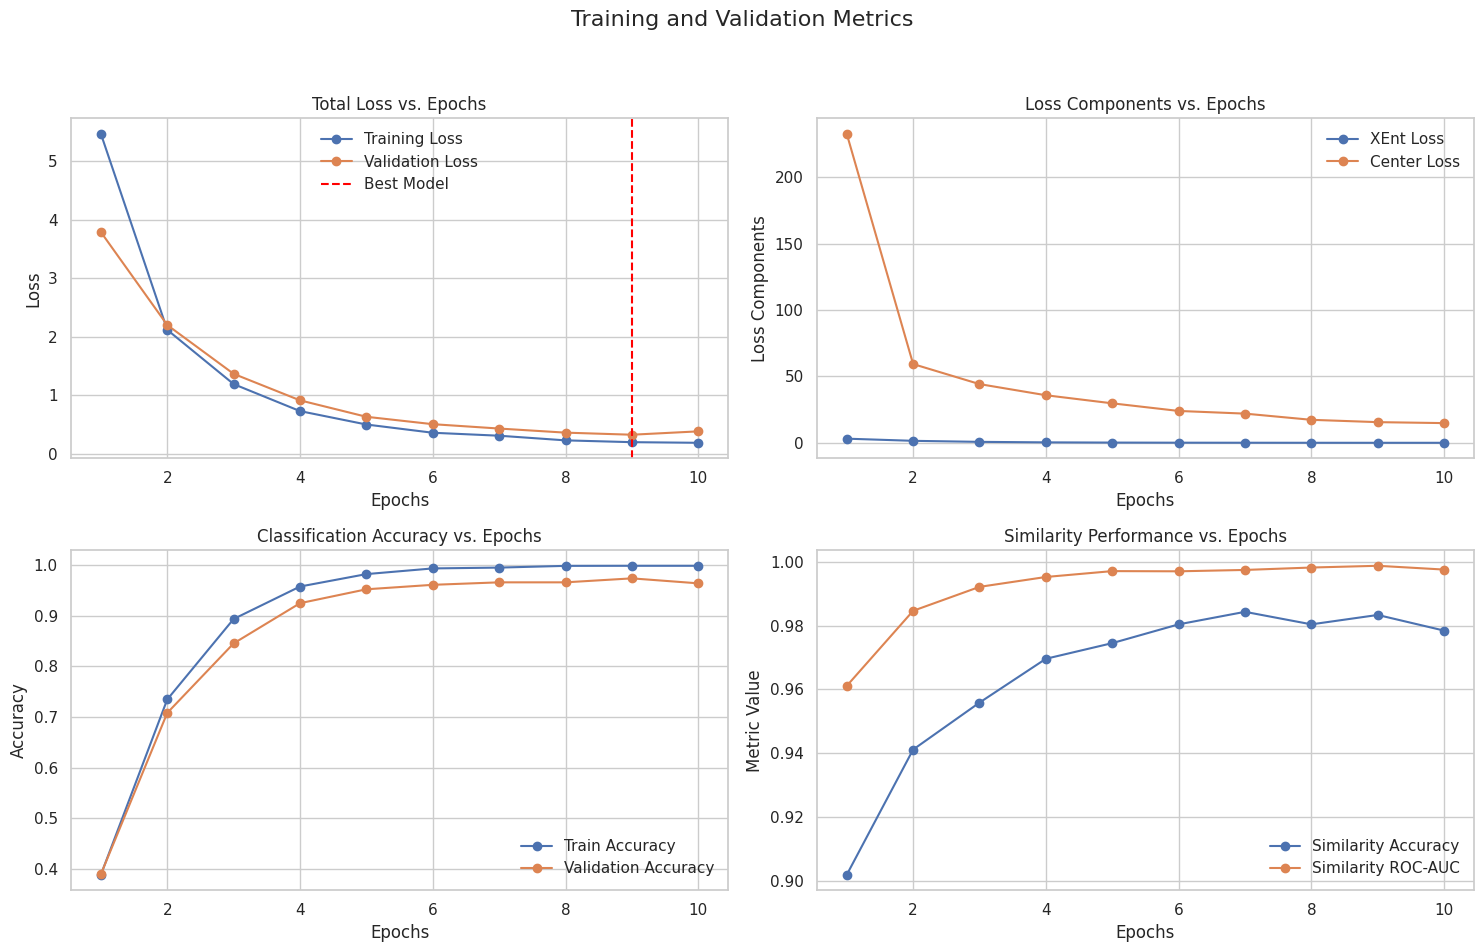

In [45]:
import os
import matplotlib.pyplot as plt
import mpld3

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training and Validation Metrics', fontsize=16)

epochs = list(range(1, len(train_losses) + 1))

# Plot Total Loss
axs[0, 0].plot(epochs, train_losses, label='Training Loss', marker='o')
axs[0, 0].plot(epochs, val_losses, label='Validation Loss', marker='o')
axs[0, 0].axvline(x=best_epoch + 1, color='red', linestyle='--', label='Best Model')
axs[0, 0].set_title('Total Loss vs. Epochs')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot Loss Components
axs[0, 1].plot(epochs, train_xent_losses, label='XEnt Loss', marker='o')
axs[0, 1].plot(epochs, train_cent_losses, label='Center Loss', marker='o')
axs[0, 1].set_title('Loss Components vs. Epochs')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss Components')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot Classification Accuracy
axs[1, 0].plot(epochs, train_accs, label='Train Accuracy', marker='o')
axs[1, 0].plot(epochs, val_accs, label='Validation Accuracy', marker='o')
axs[1, 0].set_title('Classification Accuracy vs. Epochs')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot Similarity Performance
axs[1, 1].plot(epochs, val_sim_accs, label='Similarity Accuracy', marker='o')
axs[1, 1].plot(epochs, val_sim_aucs, label='Similarity ROC-AUC', marker='o')
axs[1, 1].set_title('Similarity Performance vs. Epochs')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Metric Value')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save static image (PNG)
output_dir = CONFIG['output_dir']
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'center_loss_training_curves.png'))

# Save interactive HTML using mpld3
html_str = mpld3.fig_to_html(fig)
with open(os.path.join(output_dir, 'center_loss_training_curves_interactive.html'), 'w') as f:
    f.write(html_str)

# Show the plot (optional)
plt.show()

## Section 10: Feature Visualization

Let's visualize the feature spaces to demonstrate the effect of center loss. We'll compare the feature embeddings with and without center loss by training a model without center loss.

In [46]:
# Create a model without center loss for comparison
model_no_centerloss = CenterLossNetwork(
    backbone_name=CONFIG['backbone'],
    pretrained=True,
    embedding_dim=CONFIG['embedding_dim'],
    training_mode=CONFIG['training_mode'],
    num_classes=CONFIG['num_classes']
)
model_no_centerloss = model_no_centerloss.to(CONFIG['device'])

# Train for a few epochs without center loss
print("Training model without center loss for comparison...")

# Define cross-entropy loss and optimizer
criterion_nocloss = nn.CrossEntropyLoss()
optimizer_nocloss = optim.Adam(model_no_centerloss.parameters(), lr=CONFIG['learning_rate'])

# Train for several epochs (just for comparison)
for epoch in range(CONFIG["epochs"]):
    model_no_centerloss.train()
    running_loss = 0.0
    running_acc = 0.0
    samples = 0

    # Progress bar
    pbar = tqdm(train_loader, desc=f"Feature Viz Model - Epoch {epoch+1}/{CONFIG['epochs']}")

    for inputs, targets in pbar:
        inputs, targets = inputs.to(CONFIG['device']), targets.to(CONFIG['device'])
        batch_size = inputs.size(0)

        optimizer_nocloss.zero_grad()
        logits, _ = model_no_centerloss(inputs)
        loss = criterion_nocloss(logits, targets)
        loss.backward()
        optimizer_nocloss.step()

        # Compute accuracy
        acc = compute_accuracy(logits, targets)

        # Update statistics
        running_loss += loss.item() * batch_size
        running_acc += acc * batch_size
        samples += batch_size

        # Update progress bar
        pbar.set_postfix(
            loss=f"{loss.item():.4f}",
            acc=f"{acc:.4f}",
            avg_loss=f"{running_loss/samples:.4f}",
            avg_acc=f"{running_acc/samples:.4f}"
        )

    # Print epoch metrics
    epoch_loss = running_loss / samples
    epoch_acc = running_acc / samples
    print(f"Epoch {epoch+1}/{CONFIG['epochs']}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

print("Finished training comparison model.")

Fine-tuning mode: 2 early layers/blocks frozen, later layers trainable
Backbone: tiny_vit_5m_224.in1k, Output dimension: 320
Training mode: fine_tuning
Training model without center loss for comparison...


Feature Viz Model - Epoch 1/10:   0%|          | 0/193 [00:00<?, ?it/s]

Epoch 1/10: Loss: 2.9333, Accuracy: 0.4524


Feature Viz Model - Epoch 2/10:   0%|          | 0/193 [00:00<?, ?it/s]

Epoch 2/10: Loss: 1.0365, Accuracy: 0.8522


Feature Viz Model - Epoch 3/10:   0%|          | 0/193 [00:00<?, ?it/s]

Epoch 3/10: Loss: 0.3871, Accuracy: 0.9613


Feature Viz Model - Epoch 4/10:   0%|          | 0/193 [00:00<?, ?it/s]

Epoch 4/10: Loss: 0.1708, Accuracy: 0.9873


Feature Viz Model - Epoch 5/10:   0%|          | 0/193 [00:00<?, ?it/s]

Epoch 5/10: Loss: 0.0967, Accuracy: 0.9928


Feature Viz Model - Epoch 6/10:   0%|          | 0/193 [00:00<?, ?it/s]

Epoch 6/10: Loss: 0.0523, Accuracy: 0.9979


Feature Viz Model - Epoch 7/10:   0%|          | 0/193 [00:00<?, ?it/s]

Epoch 7/10: Loss: 0.0411, Accuracy: 0.9966


Feature Viz Model - Epoch 8/10:   0%|          | 0/193 [00:00<?, ?it/s]

Epoch 8/10: Loss: 0.0552, Accuracy: 0.9933


Feature Viz Model - Epoch 9/10:   0%|          | 0/193 [00:00<?, ?it/s]

Epoch 9/10: Loss: 0.0281, Accuracy: 0.9979


Feature Viz Model - Epoch 10/10:   0%|          | 0/193 [00:00<?, ?it/s]

Epoch 10/10: Loss: 0.0285, Accuracy: 0.9966
Finished training comparison model.


In [47]:
# Extract features from both models for visualization
def extract_features(model, dataloader, device, max_samples=2000):
    """Extract features from a model for a subset of the data."""
    model.eval()
    features = []
    labels = []
    count = 0

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Extracting features"):
            inputs, targets = inputs.to(device), targets.to(device)
            batch_features = model(inputs, get_embedding=True)

            features.append(batch_features.cpu())
            labels.append(targets.cpu())

            count += inputs.size(0)
            if count >= max_samples:
                break

    # Concatenate all features and labels
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)

    return features.numpy(), labels.numpy()

# Create a dataset for feature extraction
val_features_dataset = FlowerClassificationDataset(
    val_image_paths, val_labels,
    transforms.Compose([
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
)
val_features_loader = DataLoader(val_features_dataset, batch_size=64, shuffle=False)

# Extract features from both models
features_with_centerloss, labels_with_centerloss = extract_features(model, val_features_loader, CONFIG['device'])
features_without_centerloss, labels_without_centerloss = extract_features(model_no_centerloss, val_features_loader, CONFIG['device'])

print(f"Extracted features from both models: {features_with_centerloss.shape}")

Extracting features:   0%|          | 0/16 [00:00<?, ?it/s]

Extracting features:   0%|          | 0/16 [00:00<?, ?it/s]

Extracted features from both models: (1020, 512)


In [48]:
# Apply t-SNE for dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA # Import PCA

# Function to apply PCA followed by t-SNE
def apply_pca_tsne(features, pca_components=300, random_state=42):
    """Apply PCA to reduce dimensionality, then t-SNE to reduce to 2D."""
    print(f"Applying PCA with {pca_components} components...")
    pca = PCA(n_components=pca_components, random_state=random_state)
    pca_features = pca.fit_transform(features)
    print(f"PCA output shape: {pca_features.shape}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

    print("Applying t-SNE to PCA features...")
    tsne = TSNE(n_components=2, random_state=random_state, perplexity=30)
    tsne_features = tsne.fit_transform(pca_features)
    print(f"t-SNE output shape: {tsne_features.shape}")
    return tsne_features

# Apply PCA and t-SNE to both feature sets
tsne_with_centerloss = apply_pca_tsne(features_with_centerloss)
tsne_without_centerloss = apply_pca_tsne(features_without_centerloss)


# Create DataFrames for easier plotting
df_with_centerloss = pd.DataFrame({
    'x': tsne_with_centerloss[:, 0],
    'y': tsne_with_centerloss[:, 1],
    'label': labels_with_centerloss
})

df_without_centerloss = pd.DataFrame({
    'x': tsne_without_centerloss[:, 0],
    'y': tsne_without_centerloss[:, 1],
    'label': labels_without_centerloss
})

print("PCA and t-SNE transformation complete.")

Applying PCA with 300 components...
PCA output shape: (1020, 300)
Explained variance ratio: 0.9973
Applying t-SNE to PCA features...
t-SNE output shape: (1020, 2)
Applying PCA with 300 components...
PCA output shape: (1020, 300)
Explained variance ratio: 0.9894
Applying t-SNE to PCA features...
t-SNE output shape: (1020, 2)
PCA and t-SNE transformation complete.


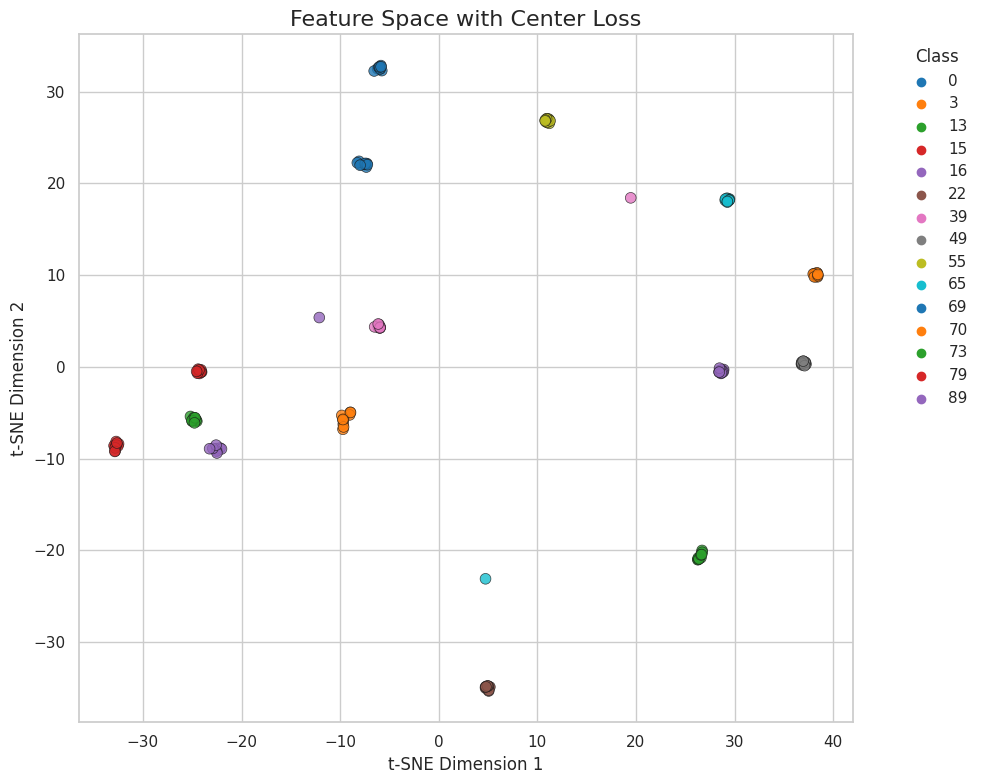

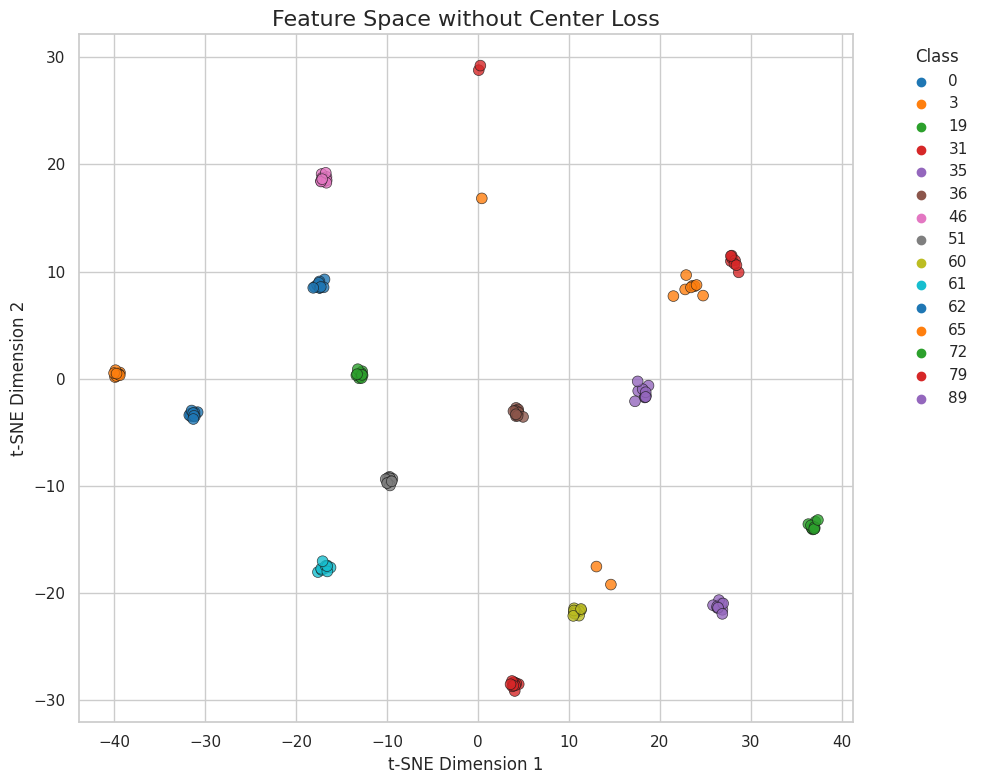

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mpld3
import os

def plot_features(df, title, output_path=None, max_classes_to_show=15):
    """Plot t-SNE features colored by class label using Matplotlib + Seaborn."""

    # Limit number of classes if too many
    unique_labels = sorted(df['label'].unique())
    if len(unique_labels) > max_classes_to_show:
        selected_classes = np.random.choice(unique_labels, max_classes_to_show, replace=False)
        df_subset = df[df['label'].isin(selected_classes)]
    else:
        df_subset = df

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df_subset,
        x='x',
        y='y',
        hue='label',
        palette='tab10',
        alpha=0.8,
        s=60,
        edgecolor='k',
        linewidth=0.5
    )
    plt.title(title, fontsize=16)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Save static PNG
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')

        # Save interactive HTML
        html_path = output_path.replace('.png', '.html')
        html_str = mpld3.fig_to_html(plt.gcf())
        with open(html_path, 'w') as f:
            f.write(html_str)

    plt.show()


# Plot both feature spaces
plot_features(
    df_with_centerloss,
    'Feature Space with Center Loss',
    os.path.join(CONFIG['output_dir'], 'tsne_with_centerloss.png')
)

plot_features(
    df_without_centerloss,
    'Feature Space without Center Loss',
    os.path.join(CONFIG['output_dir'], 'tsne_without_centerloss.png')
)

## Section 11: Evaluate on Test Set

Let's evaluate our best model on the test set to measure its final performance.

Fine-tuning mode: 2 early layers/blocks frozen, later layers trainable
Backbone: tiny_vit_5m_224.in1k, Output dimension: 320
Training mode: fine_tuning
Loaded best model from epoch 9
Validation Best Threshold: 0.9444


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Validating Similarity:   0%|          | 0/32 [00:00<?, ?it/s]


Test Set Results:
Classification - Loss: 0.3542, Accuracy: 0.9696
Similarity - Accuracy: 0.9814, ROC-AUC: 0.9971, Test Best Threshold: 0.9648


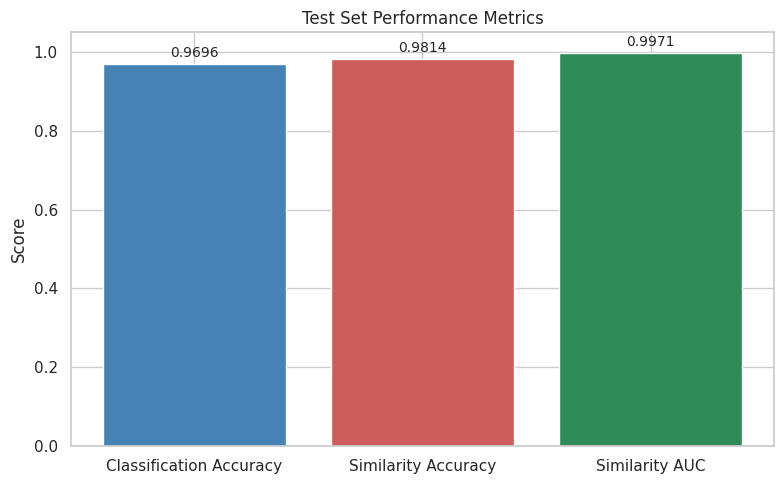

In [51]:
# Load the best model checkpoint
best_model_path = os.path.join(CONFIG['model_dir'], 'best_model_center_loss.pth')
best_checkpoint = torch.load(best_model_path, map_location=CONFIG['device'], weights_only=False)

# Instantiate model
best_model = CenterLossNetwork(
    backbone_name=best_checkpoint['config']['backbone'],
    pretrained=False,
    embedding_dim=best_checkpoint['config']['embedding_dim'],
    training_mode=best_checkpoint['config']['training_mode'],
    num_classes=best_checkpoint['config']['num_classes']
)
best_model.load_state_dict(best_checkpoint['model_state_dict'])
best_model = best_model.to(CONFIG['device'])
threshold = best_checkpoint['threshold']

print(f"Loaded best model from epoch {best_checkpoint['epoch'] + 1}")
print(f"Validation Best Threshold: {threshold:.4f}")

# Prepare test dataset and loader
test_class_dataset = FlowerClassificationDataset(
    test_image_paths, test_labels,
    transforms.Compose([
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
)
test_class_loader = DataLoader(test_class_dataset, batch_size=CONFIG['batch_size'],
                               shuffle=False, num_workers=2)

# Classification evaluation
criterion_cent.load_state_dict(best_checkpoint['center_loss_state_dict'])
test_loss, test_xent_loss, test_cent_loss, test_acc = validate_classification(
    best_model, test_class_loader, criterion_xent, criterion_cent,
    CONFIG['device'], CONFIG['center_loss_weight']
)

# Similarity evaluation
test_sim_acc, test_sim_auc, threshold = validate_similarity(
    best_model, test_loader, threshold, CONFIG['device']
)

print("\nTest Set Results:")
print(f"Classification - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
print(f"Similarity - Accuracy: {test_sim_acc:.4f}, ROC-AUC: {test_sim_auc:.4f}, Test Best Threshold: {threshold:.4f}")

# Create performance bar chart with Matplotlib
metrics = ['Classification Accuracy', 'Similarity Accuracy', 'Similarity AUC']
values = [test_acc, test_sim_acc, test_sim_auc]
colors = ['steelblue', 'indianred', 'seagreen']

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(metrics, values, color=colors)

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom', fontsize=10)

ax.set_ylim(0, 1.05)
ax.set_ylabel('Score')
ax.set_title('Test Set Performance Metrics')
plt.tight_layout()

# Save static image
output_dir = CONFIG['output_dir']
os.makedirs(output_dir, exist_ok=True)
png_path = os.path.join(output_dir, 'test_results.png')
plt.savefig(png_path)

# Optional: Save interactive HTML with mpld3
import mpld3
html_path = os.path.join(output_dir, 'test_results_interactive.html')
with open(html_path, 'w') as f:
    f.write(mpld3.fig_to_html(fig))

plt.show()

# Save test metrics to JSON
test_metrics = {
    'test_loss': test_loss,
    'test_xent_loss': test_xent_loss,
    'test_cent_loss': test_cent_loss,
    'test_classification_accuracy': test_acc,
    'test_similarity_accuracy': test_sim_acc,
    'test_similarity_auc': test_sim_auc,
    'best_epoch': best_checkpoint['epoch'] + 1,
    'backbone': CONFIG['backbone'],
    'embedding_dim': CONFIG['embedding_dim'],
    'center_loss_weight': CONFIG['center_loss_weight']
}

with open(os.path.join(output_dir, 'center_loss_test_metrics.json'), 'w') as f:
    json.dump(test_metrics, f, indent=4)

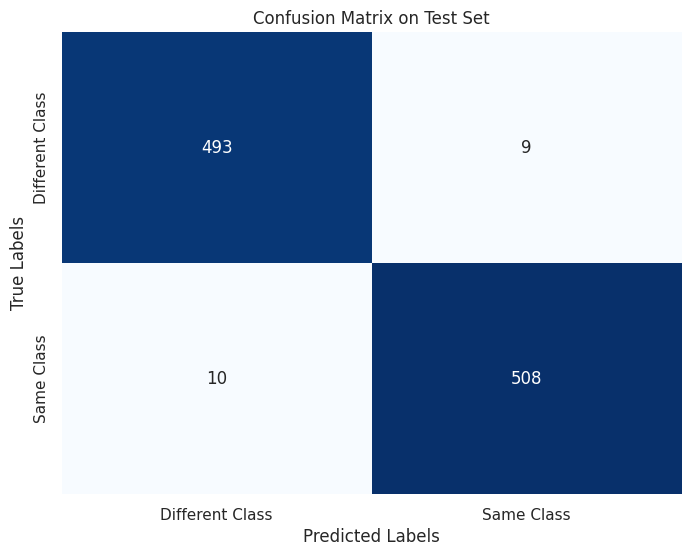


Classification Report:
                 precision    recall  f1-score   support

Different Class       0.98      0.98      0.98       502
     Same Class       0.98      0.98      0.98       518

       accuracy                           0.98      1020
      macro avg       0.98      0.98      0.98      1020
   weighted avg       0.98      0.98      0.98      1020



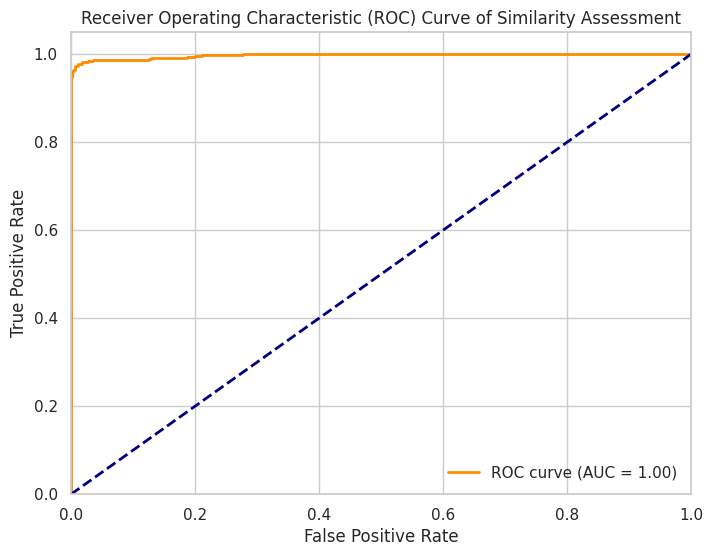

In [54]:
# Function to get all predictions and targets for similarity task
def get_all_predictions(model, dataloader, device):
    """Get all similarity predictions and targets from the dataloader."""
    model.eval()
    all_outputs = []
    all_targets = []
    all_classes = []

    with torch.no_grad():
        for (img1, img2), targets, (class1, class2) in dataloader:
            img1, img2 = img1.to(device), img2.to(device)

            # Forward pass (similarity score)
            outputs = model.compute_similarity(img1, img2)

            all_outputs.append(outputs.cpu())
            all_targets.append(targets)
            all_classes.append((class1, class2))

    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    all_classes1 = torch.cat([c[0] for c in all_classes])
    all_classes2 = torch.cat([c[1] for c in all_classes])

    return all_outputs, all_targets, (all_classes1, all_classes2)

# Get predictions and true labels
test_outputs, test_targets, (test_classes1, test_classes2) = get_all_predictions(
    best_model, test_loader, CONFIG['device']
)

# Convert to NumPy
test_probs = test_outputs.numpy()
test_preds = (test_outputs >= best_checkpoint['threshold']).float().numpy()
test_targets_np = test_targets.numpy()

# ================
# Confusion Matrix
# ================
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

cm = confusion_matrix(test_targets_np, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Test Set')
plt.xticks([0.5, 1.5], ['Different Class', 'Same Class'])
plt.yticks([0.5, 1.5], ['Different Class', 'Same Class'])
plt.savefig(os.path.join(CONFIG['output_dir'], 'confusion_matrix.png'))
plt.show()

# =====================
# Classification Report
# =====================
print("\nClassification Report:")
print(classification_report(test_targets_np, test_preds, target_names=['Different Class', 'Same Class']))

# ===========
# ROC Curve
# ===========
fpr, tpr, _ = roc_curve(test_targets_np, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of Similarity Assessment')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(os.path.join(CONFIG['output_dir'], 'roc_curve.png'))
plt.show()

## Section 12: Conclusion

In this notebook, we implemented a classification-based approach to flower similarity using center loss. Let's summarize our findings.

In [55]:
# Summarize the key results
summary = {
    'model': best_checkpoint['config']['backbone'],
    'embedding_dim': best_checkpoint['config']['embedding_dim'],
    'center_loss_weight': best_checkpoint['config']['center_loss_weight'],
    'best_epoch': best_checkpoint['epoch'] + 1,
    'test_classification_acc': test_acc,
    'test_similarity_acc': test_sim_acc,
    'test_similarity_auc': test_sim_auc,
    'validation_best_threshold': best_checkpoint['threshold'],
    'test_best_threshold': threshold
}

# Print summary
print("\nModel Summary:")
for key, value in summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")


Model Summary:
model: tiny_vit_5m_224.in1k
embedding_dim: 512
center_loss_weight: 0.0100
best_epoch: 9
test_classification_acc: 0.9696
test_similarity_acc: 0.9814
test_similarity_auc: 0.9971
validation_best_threshold: 0.9444
test_best_threshold: 0.9648


Key Insights:
1. Center loss helps create more discriminative feature embeddings by reducing intra-class variations
2. Features from the center loss model show tighter clustering by class
3. The classification-based approach provides an effective alternative to traditional Siamese networks
4. The learned feature space can be effectively used for similarity assessment
5. The combination of softmax loss and center loss offers a balance of inter-class separation and intra-class compactness
6. Classification accuracy and similarity performance are correlated but not perfectly aligned
